## Workshop Final: Título del trabajo

### Hacer el índice

En primera instancia, se cargarán todas las bibliotecas a utilizar. Algunas de ellas no se encuentran en el ambiente o requieren ser actualizadas, es por ello que dejamos las siguientes líneas comentadas para que se instalen las mismas

In [ ]:
#!pip install --upgrade pandas --user

In [ ]:
#!pip install --upgrade pandas-datareader --user

En caso que tire error cuando quiera conectarse a la API de yahoo finance (en la función evaluación), recomendamos reiniciar jupyter lab una vez instaladas y actualizadas las librerías, o bien instalarlas directamente desde anaconda promt, mediante las siguientes sintaxis:
- pip install --upgrade pandas
- pip install --upgrade pandas-datareader

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [15]:
def seasonality(df):
    df['month'] = [d.strftime('%b') for d in df.index]
    dummies_mes = pd.get_dummies(df['month'],drop_first=True)
    df = df.join(dummies_mes)
    string = 'Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep '
    return (df,string)

In [16]:
def eleccion_modelo(model,df,estacionalidad):
    if model == 'linear':
        if estacionalidad:
            df, est = seasonality(df)
            string = 'Close ~ timeIndex + Volume' + ' + ' + est
            return(df,string)
        
        string = 'Close ~ timeIndex + Volume'
        return (df,string)
    
    elif model == 'quad':
        df["timeIndex_sq"] = df["timeIndex"]**2
        if estacionalidad:
            df, est = seasonality(df)
            string = 'Close ~ timeIndex + timeIndex_sq + Volume' + ' + ' + est
            return(df,string)
        
        string = 'Close ~ timeIndex + timeIndex_sq + Volume'
        return(df,string)
    
    elif model == 'log':
        df['log_value'] = np.log(df['Close'])
        if estacionalidad:
            df, est = seasonality(df)
            string = 'log_value ~ timeIndex + Volume' + ' + ' + est
            return(df,string)
        
        string = 'log_value ~ timeIndex + Volume'
        return(df,string)
            
    

In [17]:
def evaluacion (activo,start,pred_size,lags,model,estacionalidad):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval="m")
    df = df[["Close","Volume"]]
    df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
    
    df, string = eleccion_modelo(model=model,df=df,estacionalidad=estacionalidad)
    
    df_train, df_test = train_test_split(df, test_size=pred_size, random_state=42, shuffle=False)
    
    modelo = smf.ols(string, data = df_train).fit()
    
    if estacionalidad:
        if model == 'quad':
            
            df_train['model'] = modelo.predict(df_train[["timeIndex","timeIndex_sq","Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
        
            df_test['model'] = modelo.predict(df_test[["timeIndex","timeIndex_sq", "Volume",\
                                            "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
        else:   
            df_train['model'] = modelo.predict(df_train[["timeIndex", "Volume",\
                                            "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
        
            df_test['model'] = modelo.predict(df_test[["timeIndex", "Volume",\
                                            "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
    else:
        if model == 'quad':
            df_train['model'] = modelo.predict(df_train[["timeIndex", "timeIndex_sq","Volume"]])
            df_test['model'] = modelo.predict(df_test[["timeIndex", "timeIndex_sq","Volume"]])
        else:
            df_train['model'] = modelo.predict(df_train[["timeIndex", "Volume"]])
            df_test['model'] = modelo.predict(df_test[["timeIndex", "Volume"]])

    
    
    if model == 'log':
        df_train['back_model_log_est'] = np.exp(df_train['model'])
        df_test['back_model_log_est'] = np.exp(df_test['model'])
        res_model = df_train['Close'] - df_train['back_model_log_est']
        res_log_est = df_train['log_value'] - df_train['model']
        result = adfuller(res_model)
        result1 = adfuller(res_log_est)
    else:
        res_model = df_train['Close'] - df_train['model']
        result = adfuller(res_model)
        result1 = result
        
    if result[1]<0.05:
        print("elegimos el residuo del precio de cierre - exp(log est) - p=",result[1])
        modelo = res_model
        tsplot (res_model,lags=lags)
        tipo = 1
    elif result1[1]<0.05:
        print("elegimos el residuo del log precio de cierre - log est - p=",result1[1])
        modelo = res_log_est
        tsplot (res_log_est,lags=lags)
        tipo = 2
    else:
        return print("la serie no es estacionaria, hacer mas diferenciación")
    return (modelo,df_train,df_test,tipo,model)

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [19]:
def arima (modelo,p,d,q,alpha):
    model_ARIMA = ARIMA(modelo[0], order=(p,d,q))
    results_ARIMA = model_ARIMA.fit()
    res_ARIMA =  results_ARIMA.fittedvalues - modelo[0]
    predictions_ARIMA, se, conf = results_ARIMA.forecast(len(modelo[2]['Close']), alpha=alpha)
    if modelo[3] == 1 and modelo[4] == 'log':
        modelo[1]['model_ARIMA'] = modelo[1]['back_model_log_est'] + results_ARIMA.fittedvalues
        modelo[2]['model_ARIMA'] = modelo[2]['back_model_log_est'] + predictions_ARIMA
        
    elif modelo[3] == 2 and modelo[4] == 'log':
        modelo[1]['model_ARIMA'] = np.exp(modelo[1]['model'] + results_ARIMA.fittedvalues)
        modelo[2]['model_ARIMA'] = np.exp(modelo[2]['model'] + predictions_ARIMA)
        
    else:
        modelo[1]['model_ARIMA'] = modelo[1]['model'] + results_ARIMA.fittedvalues
        modelo[2]['model_ARIMA'] = modelo[2]['model'] + predictions_ARIMA
    modelo[1].plot(kind = "line", y = ['Close', 'model_ARIMA']);
    modelo[2].plot(kind = "line", y = ['Close', 'model_ARIMA']);

elegimos el residuo del precio de cierre - exp(log est) - p= 0.01630809248702762


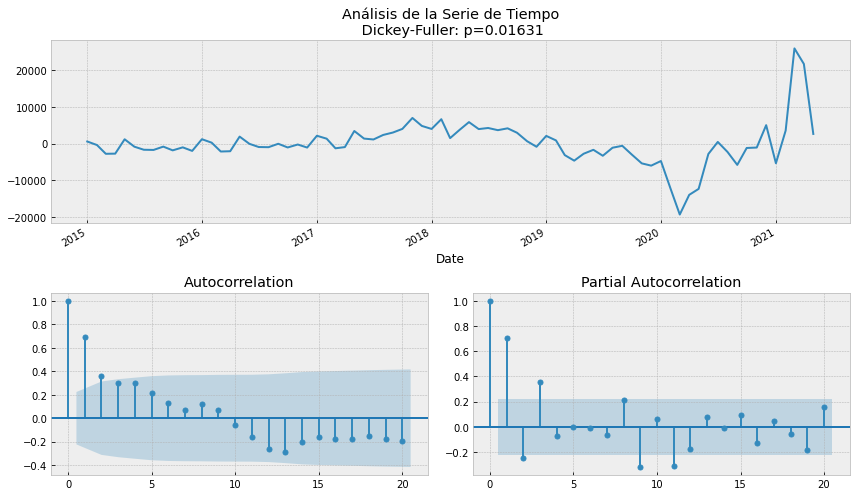

In [38]:
modelo = evaluacion("btc-usd","2015, 1, 1",6,20,model='quad',estacionalidad=True)

In [35]:
modelo[2]

,Close,Volume,timeIndex,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model
Date,,,,,,,,,,,,,,,,
2021-05-31,35040.835938,1189647451707,77,May,0,0,0,0,0,0,0,1,0,0,0,21724.545689
2021-06-30,41626.195312,819103381204,78,Jun,0,0,0,0,0,1,0,0,0,0,0,15522.129648
2021-07-31,47166.687500,1014674184428,79,Jul,0,0,0,0,1,0,0,0,0,0,0,19271.871602
2021-08-31,43790.894531,1102139678824,80,Aug,1,0,0,0,0,0,0,0,0,0,0,20063.150236
2021-09-30,53967.847656,290003645696,81,Sep,0,0,0,0,0,0,0,0,0,0,1,5669.306150
2021-10-09,54871.253906,32077387776,82,Oct,0,0,0,0,0,0,0,0,0,1,0,-2636.396403


In [39]:
modelo[2]

,Close,Volume,timeIndex,timeIndex_sq,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model
Date,,,,,,,,,,,,,,,,,
2021-05-31,35040.835938,1189647451707,77,5929,May,0,0,0,0,0,0,0,1,0,0,0,22044.437446
2021-06-30,41626.195312,819103381204,78,6084,Jun,0,0,0,0,0,1,0,0,0,0,0,15994.815430
2021-07-31,47166.687500,1014674184428,79,6241,Jul,0,0,0,0,1,0,0,0,0,0,0,19704.178280
2021-08-31,43790.894531,1102139678824,80,6400,Aug,1,0,0,0,0,0,0,0,0,0,0,20498.368934
2021-09-30,53967.847656,290003645696,81,6561,Sep,0,0,0,0,0,0,0,0,0,0,1,6418.769223
2021-10-09,54873.531250,32076206080,82,6724,Oct,0,0,0,0,0,0,0,0,0,1,0,-1693.449423


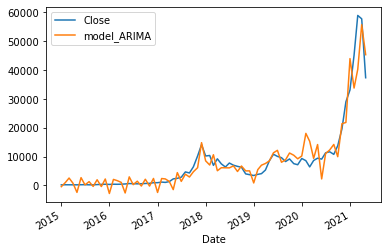

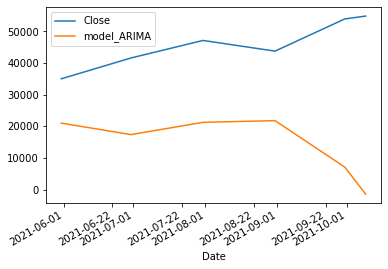

In [37]:
arima(modelo,2,0,2,0.05)

#para abajo es codigo repetido o que no utilicé arriba!

In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
df = web.get_data_yahoo("ko", start, end, interval="m")
df = df[["Close","Volume"]]

In [ ]:
df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
df['log_value'] = np.log(df['Close'])
df["sqrt"] = np.sqrt(df["Close"])

df['month'] = [d.strftime('%b') for d in df.index]
#df["day"] = [d.strftime('%d') for d in df.index]
dummies_mes = pd.get_dummies(df['month'],drop_first=True)
#dummies_dia = pd.get_dummies(df['day'],drop_first=True,prefix="day")
df = df.join(dummies_mes)
#df = df.join(dummies_dia)


In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=6, random_state=42, shuffle=False)

In [ ]:
model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()

In [ ]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [ ]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Resiudos del modelo

In [ ]:
res_model = df_train['Close'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [ ]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

Residuos del logaritmo

In [ ]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [ ]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

Residuos de la raiz cuadrada

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
lag_acf = acf(res_model, nlags = 20)
lag_acf

In [ ]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [ ]:
lag_pacf = pacf(res_model, nlags=20, method='ols');

In [ ]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(res_model, lags=40)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model_ARIMA = ARIMA(res_model, order=(2,0,4))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

In [ ]:
print(results_ARIMA.summary())

In [ ]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

In [ ]:
results_ARIMA.plot_predict(end=len(df['Close']));

In [ ]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

In [ ]:
tsplot(res_ARIMA, lags=20)

In [ ]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Close']), alpha=0.05)

In [ ]:
df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues

correccion = + df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]

df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA


In [ ]:
df_train.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [ ]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Model + est + ARIMA"
df_Results.loc[0, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['Close'])
df_Results

In [ ]:
df_test.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [ ]:
df_test

In [ ]:
df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]